In [1]:
import time
import numpy as np
import pandas as pd
from textblob import TextBlob
import sklearn
from pycorenlp import StanfordCoreNLP
from micromort.utils.classification_plotter import plot_classification_report
import sys
reload(sys)
sys.setdefaultencoding('utf8')
#from newspaper import Article
from multiprocessing.dummy import Pool as ThreadPool

In [101]:
data_dump = pd.read_csv("../../data/annotator_data_dump_with_polarity")
data_dump = data_dump[data_dump.polarity != 9].reset_index(drop=True)

In [102]:
data_dump = data_dump.drop(['category'], axis=1).drop_duplicates()

In [4]:
data_dump['e'] = pd.Series(np.zeros(data_dump.shape[0]), index=data_dump.index)
data_dump.head()

,url,summary,title,polarity,e,text
0,http://www.straitstimes.com/world/united-state...,WASHINGTON (REUTERS) - Russian government-back...,Russian hackers said to have stolen US cyber s...,-1,0.0,WASHINGTON (REUTERS) - Russian government-back...
2,http://www.channelnewsasia.com/news/health/to-...,(Reuters Health) - The best way to get teens t...,"To grow teen athletes, let kids try lots of sp...",0,0.0,LONDON: The best way to get teens to play spor...
3,http://www.straitstimes.com/asia/se-asia/prote...,JAKARTA/KUALA LUMPUR - Muslim protesters ralli...,Protests in Asia against Trump's decision on J...,-1,0.0,JAKARTA/KUALA LUMPUR - Muslim protesters ralli...
5,http://www.asiaone.com/health/zika-virus-singa...,SINGAPORE - Analysis of the Zika virus found i...,Zika virus in Singapore likely from Asian stra...,-1,0.0,SINGAPORE - Analysis of the Zika virus found i...
6,http://www.asiaone.com/health/good-or-bad-look...,"Canola oil, which is extracted from the seeds ...",Good or bad? A look at myths and facts about c...,-1,0.0,SINGAPORE - Canola oil used to be the healthy ...


In [109]:
for index, row in data_dump.iterrows():
    data = row["title"]
    blob = TextBlob(data.decode('utf-8').strip())
    if (blob.sentiment.polarity < .05 and blob.sentiment.polarity > -.05):
        data_dump["e"].values[index] = 0
    elif (blob.sentiment.polarity > .1):
        data_dump["e"].values[index] = 1
    else: 
        data_dump["e"].values[index] = -1

IndexError: index 1847 is out of bounds for axis 0 with size 1847

In [110]:
sklearn.metrics.accuracy_score(data_dump["e"].values, data_dump["polarity"].values)

0.3069842988630211

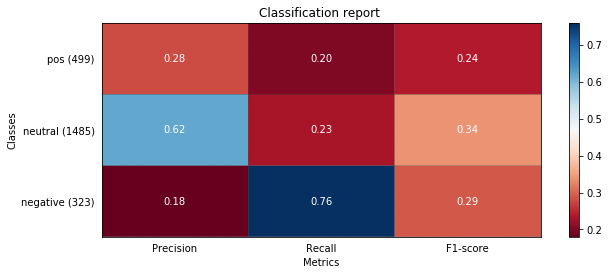

In [6]:
plot_classification_report(sklearn.metrics.classification_report(data_dump["e"].values, data_dump["polarity"].values, target_names=["negative", "neutral", "pos"]))

## Standford Deeply Moving: Deep Learning for Sentiment Analysis

In [103]:
data_dump['stan_body'] = pd.Series(np.zeros(data_dump.shape[0]), index=data_dump.index)
data_dump['stan_title'] = pd.Series(np.zeros(data_dump.shape[0]), index=data_dump.index)

In [104]:
nlp = StanfordCoreNLP('http://gpu:9000')
def get_sentiment(x):
    res = nlp.annotate(x,
                       properties={
                           'annotators': 'sentiment',
                           'outputFormat': 'json'
                       })
    try:
        return res["sentences"][0]["sentiment"]
    except Exception:
        print Exception
        return ""

In [105]:
def myFun(row):
    d = {
            "stan_body" : 2,
            "polarity" : row[4]
        }
    try:
        data = str(row[6].encode('ascii',errors='ignore')[:500])
        #data = str(row[3].encode('ascii',errors='ignore'))
        sentiment = get_sentiment(data)
        if (sentiment == "Neutral"):
            d["stan_body"] = 0
        elif (sentiment == "Verynegative"):
            d["stan_body"] = -1
        elif (sentiment == "Verypositive"):
            d["stan_body"] = 1
        elif (sentiment == "Positive"):
            d["stan_body"] = 1
        elif (sentiment == "Negative"):
            d["stan_body"] = -1
        else:
            d["stan_body"] = 2
    except Exception as e:
        print e
    return d

pool = ThreadPool(6)
final_results = pool.map(myFun, list(data_dump.itertuples()))

In [106]:
d = pd.DataFrame(final_results)

In [107]:
pd.DataFrame({'count' : d.groupby( [ "stan_body"] ).size()}).reset_index()

,stan_body,count
0,-1,1596
1,0,122
2,1,106
3,2,23


In [76]:
d = d[d.stan_body!=2]

In [108]:
data_dump["stan_body"] = d["stan_body"]

In [111]:
pd.DataFrame({'count' : data_dump.groupby( [ "stan_body"] ).size()}).reset_index()

,stan_body,count
0,-1.0,1290
1,0.0,94
2,1.0,91
3,2.0,19


### On title

In [45]:
sklearn.metrics.accuracy_score(d["e"].values, d["polarity"].values)

0.47698971304818627

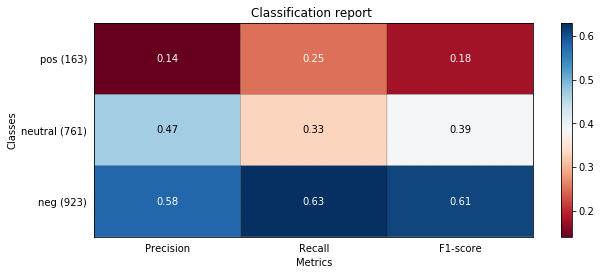

In [46]:
plot_classification_report(sklearn.metrics.classification_report(d["e"].values, d["polarity"].values, target_names=["neg", "neutral", "pos"]))

### On full body

In [60]:
sklearn.metrics.accuracy_score(d["e"].values, d["polarity"].values)

0.5350140056022409

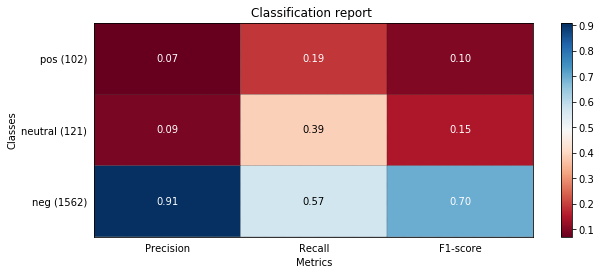

In [62]:
plot_classification_report(sklearn.metrics.classification_report(d["e"].values, d["polarity"].values, target_names=["neg", "neutral", "pos"]))

### On body(500 chars)

In [94]:
d = data_dump[data_dump.stan_body != 2]

In [117]:
data_dump[data_dump.stan_body != 1][data_dump.stan_body != -1][data_dump.stan_body != 0]

,url,summary,title,polarity,e,text,stan_body,stan_title
160,http://www.asiaone.com/digital/laptop-review-a...,Acer does many things right with its latest bu...,Laptop review: Acer TravelMate P645,0,0.0,Acer does many things right with its latest bu...,2.0,0.0
174,http://www.asiaone.com/health/block-bites-woma...,"One by one, the family of four living in a fiv...","Block of bites: Woman, daughters, grandchild h...",-1,0.0,SINGAPORE - One household in the worst-hit den...,2.0,0.0
191,http://www.asiaone.com/health/how-get-shape-ch...,"On paper, it seems like a no-brainer - exercis...",How to get into shape by Christmas,1,0.0,We all need to exercise. But how can we get wh...,2.0,0.0
236,http://www.asiaone.com/digital/pakistans-youtu...,ISLAMABAD - For those who have been able to ac...,Pakistan's YouTube 'unblocking' a short-lived joy,-1,0.0,ISLAMABAD - For those who have been able to ac...,2.0,0.0
406,http://www.straitstimes.com/forum/letters-in-p...,The recent comments by Home Affairs and Law Mi...,More effective ways to fight radicalism needed,-1,1.0,The recent comments by Home Affairs and Law Mi...,2.0,0.0
422,http://www.straitstimes.com/asia/australianz/n...,WELLINGTON (AFP) - Both of New Zealand's major...,New Zealand leaders line up to woo kingmaker P...,0,0.0,WELLINGTON (AFP) - Both of New Zealand's major...,2.0,0.0
457,http://www.asiaone.com/asia/singapore-firm-bri...,"SQFT Global Properties, a real estate agency h...",Singapore firm brings Bangkok condos to Myanmar,0,0.0,"SQFT Global Properties, a real estate agency h...",2.0,0.0
487,http://www.asiaone.com/health/shrinking-unsigh...,"Embolisation, another minimally invasive techn...",Shrinking unsightly lumps,1,-1.0,"I saw Mr WS, a 28-year-old from Malaysia, abou...",2.0,0.0
506,http://www.channelnewsasia.com/news/world/russ...,Russia's central election commission on Wednes...,Russia's Putin registers re-election bid,0,0.0,Russia's central election commission on Wednes...,2.0,0.0
658,http://www.asiaone.com/health/some-opt-transpl...,"PETALING JAYA - Madam Chin, in her 60s, return...",Some opt for transplants overseas due to long ...,0,0.0,"PETALING JAYA - Madam Chin, in her 60s, return...",2.0,0.0


In [116]:
sklearn.metrics.accuracy_score(d["stan_body"].values, d["polarity"].values)

0.5268002165674066

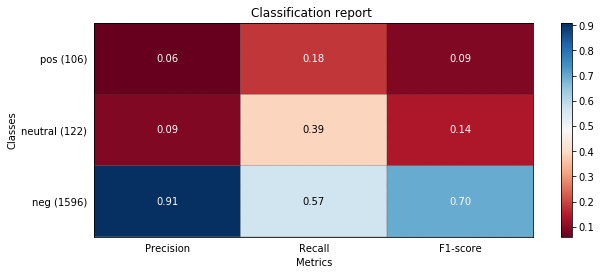

In [69]:
plot_classification_report(sklearn.metrics.classification_report(d["e"].values, d["polarity"].values, target_names=["neg", "neutral", "pos"]))

## Pattern : https://www.clips.uantwerpen.be/pages/pattern-en#sentiment

In [118]:
from pattern.en import sentiment

In [127]:
def myFun(row):
    d = {
            "e" : 2,
            "polarity" : row[4]
        }
    try:
        global sentiment
        data = str(row[3].encode('ascii',errors='ignore'))
        _sentiment = sentiment(data)[0]
        print _sentiment
        if _sentiment > .1:
            d["e"] = 1
        elif _sentiment < 0:
            d["e"] = -1
        else:
            d["e"] = 0
    except Exception as e:
        print e
    return d

pool = ThreadPool(6)
final_results = pool.map(myFun, list(data_dump.itertuples()))

In [128]:
d = pd.DataFrame(final_results)

In [129]:
pd.DataFrame({'count' : d.groupby( [ "e"] ).size()}).reset_index()

,e,count
0,-1,261
1,0,1180
2,1,406


In [130]:
data_dump.shape, d.shape

((1847, 8), (1847, 2))

In [97]:
d = d[d.e!=2]

### On body

In [122]:
sklearn.metrics.accuracy_score(d["e"].values, d["polarity"].values)

0.33567948023822414

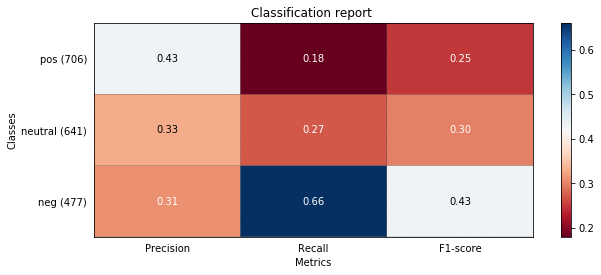

In [123]:
plot_classification_report(sklearn.metrics.classification_report(d["e"].values, d["polarity"].values, target_names=["neg", "neutral", "pos"]))

### On title

In [131]:
sklearn.metrics.accuracy_score(d["e"].values, d["polarity"].values)

0.32485110990795885

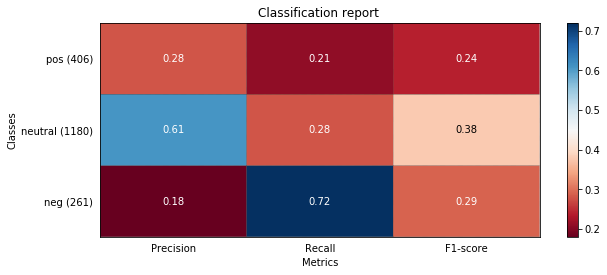

In [132]:
plot_classification_report(sklearn.metrics.classification_report(d["e"].values, d["polarity"].values, target_names=["neg", "neutral", "pos"]))

## VADER

In [133]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [148]:
def myFun(row):
    d = {
            "e" : 2,
            "polarity" : row[4]
        }
    try:
        global analyzer
        data = str(row[3].encode('ascii',errors='ignore'))
        _sentiment = analyzer.polarity_scores(data)["compound"]
        print _sentiment
        if _sentiment >= 0.05:
            d["e"] = 1
        elif _sentiment <= -0.05:
            d["e"] = -1
        else:
            d["e"] = 0
    except Exception as e:
        print e
    return d

pool = ThreadPool(6)
final_results = pool.map(myFun, list(data_dump.itertuples()))

In [149]:
d = pd.DataFrame(final_results)

In [150]:
pd.DataFrame({'count' : d.groupby( [ "e"] ).size()}).reset_index()

,e,count
0,-1,677
1,0,740
2,1,430


In [151]:
data_dump["vader_title"] = d["e"]

In [22]:
d = d[d.e!=2]

In [153]:
data_dump

,url,summary,title,polarity,e,text,stan_body,stan_title,vader_body,vader_title
0,http://www.straitstimes.com/world/united-state...,WASHINGTON (REUTERS) - Russian government-back...,Russian hackers said to have stolen US cyber s...,-1,0.0,WASHINGTON (REUTERS) - Russian government-back...,-1.0,0.0,1.0,-1.0
2,http://www.channelnewsasia.com/news/health/to-...,(Reuters Health) - The best way to get teens t...,"To grow teen athletes, let kids try lots of sp...",0,-1.0,LONDON: The best way to get teens to play spor...,-1.0,0.0,0.0,-1.0
3,http://www.straitstimes.com/asia/se-asia/prote...,JAKARTA/KUALA LUMPUR - Muslim protesters ralli...,Protests in Asia against Trump's decision on J...,-1,0.0,JAKARTA/KUALA LUMPUR - Muslim protesters ralli...,-1.0,0.0,-1.0,0.0
5,http://www.asiaone.com/health/zika-virus-singa...,SINGAPORE - Analysis of the Zika virus found i...,Zika virus in Singapore likely from Asian stra...,-1,0.0,SINGAPORE - Analysis of the Zika virus found i...,-1.0,0.0,-1.0,-1.0
6,http://www.asiaone.com/health/good-or-bad-look...,"Canola oil, which is extracted from the seeds ...",Good or bad? A look at myths and facts about c...,-1,1.0,SINGAPORE - Canola oil used to be the healthy ...,-1.0,0.0,1.0,0.0
7,http://www.asiaone.com/china/china-punishes-of...,SHANGHAI - China has punished officials in the...,China punishes officials for tampering with sm...,-1,0.0,Beijing plans to establish an environmental po...,-1.0,0.0,1.0,0.0
9,http://www.asiaone.com/digital/upcoming-featur...,Return of the Start menu: Windows 10 brings ba...,The upcoming features in Windows 10,0,0.0,Return of the Start menu: Windows 10 brings ba...,-1.0,0.0,-1.0,-1.0
10,http://www.straitstimes.com/world/middle-east/...,RIYADH (AFP) - Saudi Arabian women will be abl...,Saudi women will also be allowed to drive moto...,1,0.0,RIYADH (AFP) - Saudi Arabian women will be abl...,-1.0,0.0,1.0,0.0
11,http://www.straitstimes.com/asia/se-asia/zodia...,KUALA LUMPUR - Chinese across the world are pr...,"Zodiac dog, pig go missing for Chinese New Yea...",-1,0.0,KUALA LUMPUR - Chinese across the world are pr...,-1.0,0.0,-1.0,0.0
12,http://www.asiaone.com/health/men-face-higher-...,"For men, the risk of HPV-driven cancers of the...",Men face higher risk of cancers linked to oral...,-1,0.0,WASHINGTON - Men are twice as likely as women ...,-1.0,0.0,-1.0,0.0


In [158]:
1.0*data_dump[data_dump.vader_body == data_dump.vader_title].shape[0]/data_dump.shape[0]

0.3779101245262588

In [160]:
1.0*data_dump[data_dump.vader_body == data_dump.stan_body].shape[0]/data_dump.shape[0]

0.41147807255008123

#### On body

In [143]:
sklearn.metrics.accuracy_score(d["e"].values, d["polarity"].values)

0.4932322685435842

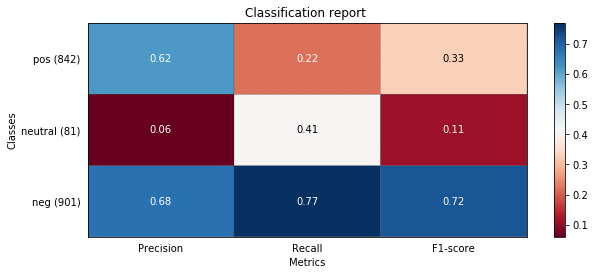

In [144]:
plot_classification_report(sklearn.metrics.classification_report(d["e"].values, d["polarity"].values, target_names=["neg", "neutral", "pos"]))

#### On title

In [23]:
sklearn.metrics.accuracy_score(d["e"].values, d["polarity"].values)

0.511099079588522

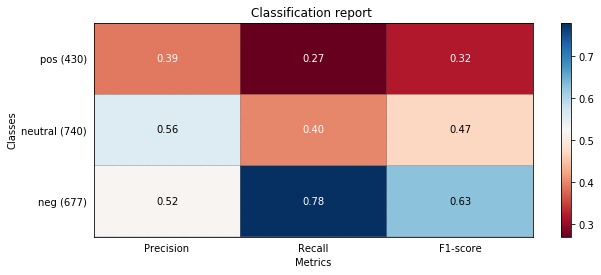

In [24]:
plot_classification_report(sklearn.metrics.classification_report(d["e"].values, d["polarity"].values, target_names=["neg", "neutral", "pos"]))

### aylien APIs

In [111]:
from aylienapiclient import textapi
client = textapi.Client("06ef7dde", "37bd8e6e7eaaec39510f8de755821293")

In [113]:
count=0
for index, row in data_dump.iterrows():
    data_dump["e"].values[index] = 2
    try:
        data = row["text"].encode('utf-8').strip()
        sentiment = client.Sentiment({'text':data})["polarity"]
    except Exception as e:
        print e
    print sentiment
    if (sentiment == "Neutral" or sentiment == 'neutral'):
        data_dump["e"].values[index] = 0
    elif (sentiment == "Positive" or sentiment == "positive"):
        data_dump["e"].values[index] = 1
    else: 
        data_dump["e"].values[index] = -1
    if count%60 == 0:
        print count
        time.sleep(60)
    count=count+1
    

KeyboardInterrupt: 

In [114]:
sklearn.metrics.accuracy_score(data_dump["e"].values[:660], data_dump["polarity"].values[:660])

0.33484848484848484

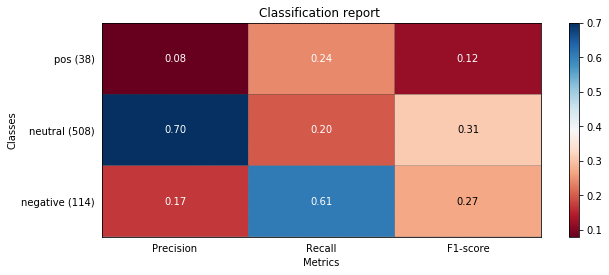

In [50]:
plot_classification_report(sklearn.metrics.classification_report(data_dump["e"].values[:660], data_dump["polarity"].values[:660], target_names=["negative", "neutral", "pos"]))

## Azure

In [35]:
import httplib, urllib, base64, json

headers = {
    # Request headers
    'Content-Type': 'application/json',
    'Ocp-Apim-Subscription-Key': '9116275d25b042138905e5f73af44138',
}

params = urllib.urlencode({})
conn = httplib.HTTPSConnection('southeastasia.api.cognitive.microsoft.com')

In [62]:
#data_dump['azure_score'] = pd.Series(np.zeros(data_dump.shape[0]), index=data_dump.index)
data_dump['azure_pred'] = pd.Series(np.zeros(data_dump.shape[0]), index=data_dump.index)
#data_dump['azure_score_title'] = pd.Series(np.zeros(data_dump.shape[0]), index=data_dump.index)

In [53]:
count = 0
for index, row in data_dump.iterrows():
    try:    
        data = row["title"].encode('utf-8').strip()
        j = {"documents": [{"id":"1", "text":data}]}
        conn.request("POST", "/text/analytics/v2.0/sentiment?%s" % params, json.dumps(j), headers)
        response = conn.getresponse()
        resp = response.read()
        score = json.loads(resp)["documents"][0]["score"]
        data_dump["azure_score_title"].values[index] = score
    except Exception as e:
        print e
    
    conn.close()
    if count%5 == 0:
        time.sleep(1)
    count = count+1

In [54]:
data_dump[data_dump.azure_score > .5].shape

(65, 10)

In [63]:
data_dump.loc[data_dump['azure_score_title'] < .3, 'azure_pred'] = -1
data_dump.loc[data_dump['azure_score_title'] > .6, 'azure_pred'] = 1
#data_dump.loc[data_dump['azure_score_title'] > .3 and data_dump['azure_score_title'] < .6, 'azure_pred'] = 0

In [48]:
pd.DataFrame({'count' : data_dump.groupby( [ "azure_pred"] ).size()}).reset_index()

,azure_pred,count
0,-1.0,1208
1,0.0,551
2,1.0,65


In [64]:
pd.DataFrame({'count' : data_dump.groupby( [ "azure_pred"] ).size()}).reset_index()

,azure_pred,count
0,-1.0,1397
1,0.0,263
2,1.0,164


### Body

In [49]:
sklearn.metrics.accuracy_score(data_dump["azure_pred"].values, data_dump["polarity"].values)

0.4643640350877193

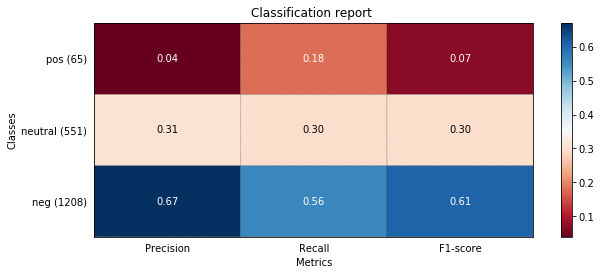

In [51]:
plot_classification_report(sklearn.metrics.classification_report(data_dump["azure_pred"].values, data_dump["polarity"].values, target_names=["neg", "neutral", "pos"]))

### Title

In [58]:
sklearn.metrics.accuracy_score(data_dump["azure_pred"].values, data_dump["polarity"].values)

0.47039473684210525

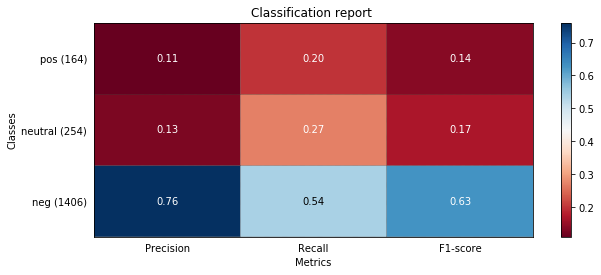

In [59]:
plot_classification_report(sklearn.metrics.classification_report(data_dump["azure_pred"].values, data_dump["polarity"].values, target_names=["neg", "neutral", "pos"]))

In [200]:
b = data_dump

In [210]:
for index, row in b.iterrows():
    data = row["text"].encode('utf-8').strip()
    b["text"].values[index] = re.sub(r"[\"\n\s+]", " ", row["text"])
#re.sub(r"[\"\n\s+]", " " ,b["text"][0])

## Gcloud

In [5]:
import argparse
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

In [13]:
def print_result(annotations):
    score = annotations.document_sentiment.score
    magnitude = annotations.document_sentiment.magnitude

#     for index, sentence in enumerate(annotations.sentences):
#         sentence_sentiment = sentence.sentiment.score
#         print('Sentence {} has a sentiment score of {}'.format(
#             index, sentence_sentiment))
    
#     print('Overall Sentiment: score of {} with magnitude of {}'.format(
#         score, magnitude))
    return score

client = language.LanguageServiceClient()

count=0
for index, row in data_dump.iterrows():
    data_dump["e"].values[index] = 2
    try:
        data = row["text"].encode('utf-8').strip()
        document = types.Document(content=data, type=enums.Document.Type.PLAIN_TEXT)
        annotations = client.analyze_sentiment(document=document)
        data_dump["e"].values[index] = print_result(annotations)
        
    except Exception as e:
        print e
    if count%60 == 0:
        print count
        time.sleep(5)
    count=count+1

# Print the results
#print_result(annotations)

KeyboardInterrupt: 

In [17]:
data_dump = data_dump[data_dump.e!=2]

In [19]:
data_dump['gcloud'] = pd.Series(np.zeros(data_dump.shape[0]), index=data_dump.index)

In [20]:
data_dump['gcloud'] = data_dump["e"]

In [7]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/mannu/key.json"

In [28]:
#data_dump[data_dump.gcloud < 0].gcloud = -1
data_dump.loc[data_dump['gcloud'] < 0, 'gcloud'] = -1

In [29]:
pd.DataFrame({'count' : data_dump.groupby( [ "gcloud"] ).size()}).reset_index()

,gcloud,count
0,-1.0,612
1,0.0,869
2,1.0,343


In [32]:
sklearn.metrics.accuracy_score(data_dump["gcloud"].values, data_dump["polarity"].values)

0.3442982456140351

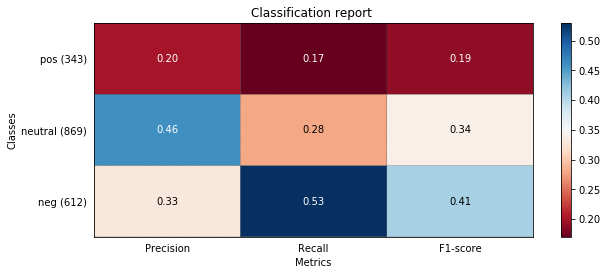

In [34]:
plot_classification_report(sklearn.metrics.classification_report(data_dump["gcloud"].values, data_dump["polarity"].values, target_names=["neg", "neutral", "pos"]))